### The model that will adjust the volume based on:
- outside sound from mics
- current music ?
- preferences ???

curr_db -> int32 between 48db(e 0 la PC), 127(e 100 la PC)  
outside_sound -> one-dimensional array with 3762 elements (memory limitations for rtos task)

In [1]:
import sounddevice as sd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import json
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
print(tf.__version__)

2.4.0


In [2]:
#tf.debugging.set_log_device_placement(True)
#tf.config.set_soft_device_placement(True)
#tf.compat.v1.enable_eager_execution()
data_path = ".\\outside_data\\"
meta_file = "rec_file.txt"
fs = 44100 // 2
duration = 1
sig_len = fs * duration # sound length
array_len = 3675 # array length for psoc (sig_len / 6)
batch_size = 24 # ?? mai vad cat sa pun i guess
psoc_start = 48 # la psoc e mai mare rangeul dar poate merge asa
psoc_stop = 127

In [3]:
# function definitions
def normalization(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

def standardization(arr):
    return (arr - np.mean(arr)) / np.std(arr)

def volume_normalization(vol):
    #linear_vol = vol ** (vol / 10)
    #linear_start = psoc_start ** (vol / 10)
    #linear_stop = psoc_stop ** (vol / 10)
    #return (linear_vol - linear_start) / (linear_stop - linear_start)
    return (vol - psoc_start) / (psoc_stop - psoc_start)

def volume_denormalization(vol):
    return (psoc_stop - psoc_start) * vol + psoc_start

def get_fft(arr):
    data_ftt = np.fft.fft(arr)
    data_ftt = np.abs(data_ftt.real)[:len(arr)//2]
    return data_ftt

def fft2img(data):
    _, _, _, ret = plt.specgram(x=data.flatten(), NFFT=256, Fs=22050)
    return ret.make_image(None)[0][:,:,:3]

In [4]:
# loading from file
data_array = []
with open(meta_file, 'r') as f:
    lines = f.readlines()
    for line in lines:
        obj = json.loads(line.replace('\n',''))
        data_array.append(obj)

#print(data_array)

In [5]:
# create a helper class to load a batch of data on request
# idx = 10, pos = 10 * bs
class DataLoader(keras.utils.Sequence):
    def __init__(self, data, batch_size, data_path, shuffle=True):
        #if not isinstance(data, np.ndarray):
        #    raise Exception("Bad type for data in loader...hass to be np.array")
        self.data = data # nparray 
        self.batch_size = batch_size // 6
        self.data_path = data_path
        self.shuffle = shuffle
        if self.shuffle == True:
            np.random.shuffle(self.data)
    
    # returns the number of batches
    def __len__(self):
        return len(self.data) // self.batch_size
    
    # gets one batch
    def __getitem__(self, idx):
        data_batch = self.data[idx * self.batch_size : (idx + 1) * self.batch_size]
        in1 = []
        y = []
        for db in data_batch:
            snd_data = np.load(self.data_path + db['outside_sound'])
            snd_data = snd_data.astype(np.float32)
            curr_vol = db['current_vol']
            label = db['pref_vol']
            #label = label.astype(np.float32)
            # normalization & standardization ?
            #snd_data = normalization(snd_data)
            curr_vol = volume_normalization(curr_vol)
            label = volume_normalization(label)
            snd_data = snd_data.reshape(-1,1)
            #snd_data = np.append(snd_data,[curr_vol])
            for i in range(0,6):
                in1.append(snd_data[i * array_len: (i+1) * array_len])
                y.append(label)
            
        in1 = np.asarray(in1)
        y = np.asarray(y)

        y = y.astype(np.float32)

        return in1, y
    
    # returns the label (don't think i need it tho)
    # def __to_categorical(self, data):
    #     ret_val = 0
    #     if data == "open":
    #         ret_val = np.array([1,0,0])
    #     elif data == "close":
    #         ret_val = np.array([0,1,0])
    #     else:
    #         ret_val = np.array([0,0,1])
    #     return ret_val
    
    #shuffle items after each epoch
    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.data)

In [6]:
#loading data in data loader
data_array = np.asarray(data_array,dtype=dict)
print(data_array.shape)
np.random.shuffle(data_array)
#print(data_array)

#splitting the data in training, validation and test samples
training_vals, validation_vals, test_vals = np.split(data_array, [int(len(data_array)*0.6), int(len(data_array)*0.9)])

training_loader = DataLoader(np.asarray(training_vals), batch_size, data_path)
validation_loader = DataLoader(np.asarray(validation_vals), batch_size, data_path)
test_loader = DataLoader(np.asarray(test_vals), batch_size, data_path)

#length is the batch size
print("Data len:" ,len(data_array), " Training data len:", len(training_loader), " Validation data len:", len(validation_loader), " Test data:", len(test_loader))

sample = training_loader.__getitem__(5)
print(f"Sample - len: {len(sample)}; shape[0]: {sample[0].shape}; shape[1]: {sample[1].shape}; shape[0][0]: {sample[0][0].shape}")
#print(f"Sample[0] - {sample[0]};\nSample[1]: {sample[1]})

(2410,)
Data len: 2410  Training data len: 361  Validation data len: 180  Test data: 60
Sample - len: 2; shape[0]: (24, 3675, 1); shape[1]: (24,); shape[0][0]: (3675, 1)


In [7]:
# custom layer for fft
# not supported unfortunately
class FFT_Image(keras.layers.Layer):

    def __init__(self, shape, name=None, **kwargs):
        super(FFT_Image, self).__init__(trainable=False, name=None, dynamic=True,**kwargs)
        self.shape = shape
        self.build(shape)

    def get_config(self):
        config = super().get_config()
        config.update({
            "shape": self.shape
        })
        return config

    def build(self, input_shape): 
        super(FFT_Image, self).build(input_shape)

    def compute_output_shape(self, input_shapes):
        IM_H = 335
        IM_W = 218
        IM_CH = 3
        return tf.TensorShape([input_shapes[0], IM_W, IM_H, IM_CH])

    def call(self, inputs, *args, **kwargs):
        rets = []
        for input in inputs: 
            data_ftt = np.fft.fft(input.numpy())
            data_ftt = np.abs(data_ftt.real)[:len(input.numpy())//2]
            _, _, _, ret = plt.specgram(x=data_ftt.flatten(), NFFT=256, Fs=22050)
            ret = ret.make_image(None)[0][:,:,:3]
            rets.append(ret)
        return tf.convert_to_tensor(np.asarray(rets, dtype=np.float64))
        

In [8]:
# creating the model
# !!! doesn't support multi-input or lambda layer !!!
# lambda layer pare puternic

def lambda_first_layer(x):
    import tensorflow as tf
    tensors = tf.unstack(x, axis=1)
    del tensors[-1]
    t = tf.stack(tensors,1)
    #print(t.shape)
    return t

def lambda_get_volume(x):
    import tensorflow as tf
    tensors = tf.unstack(x, axis=1)
    #print(len(tensors))
    del tensors[:88200]
    t = tf.stack(tensors,1)
    #print(t.shape)
    return t

#lambda_first_layer(sample[0])

data_in = keras.Input(shape=(array_len,1,), batch_size=batch_size,dtype=np.float32)

# layers for the outside_sound
#val = keras.layers.Lambda(lambda_first_layer)(data_in)
#val = keras.layers.Reshape((sig_len,1))(val)
val = keras.layers.Conv1D(32, 15, activation=keras.activations.relu, name="Conv1D_snd_1")(data_in)
val = keras.layers.BatchNormalization()(val)
#val = keras.activations.relu(val)

val = keras.layers.Dropout(0.5)(val)
val = keras.layers.AveragePooling1D(8)(val)

val = keras.layers.Conv1D(16, 11, activation=keras.activations.relu)(val)
val = keras.layers.BatchNormalization()(val)
#val = keras.activations.relu(val)

val = keras.layers.Dropout(0.5)(val)
val = keras.layers.MaxPool1D(2)(val)
# val = keras.layers.Dense(16)(val)
# val = keras.layers.BatchNormalization()(val)
# val = keras.layers.Dropout(0.5)(val)
#val = keras.layers.Flatten()(val)

# layers for the current volume
#val2 = keras.layers.Lambda(lambda_get_volume)(data_in)
#val2 = keras.layers.Reshape(target_shape=(1,1))(val2)
val2 = keras.layers.Dense(20)(val)
val2 = keras.layers.BatchNormalization()(val2)
val2 = keras.layers.Dropout(0.5)(val2)
val2 = keras.layers.Dense(16)(val2)
val2 = keras.layers.BatchNormalization()(val2)
val2 = keras.layers.Dropout(0.5)(val2)
#val2 = keras.activations.relu(val2)
#val2 = keras.layers.Flatten()(val2)
#val2 = keras.layers.Dropout(0.5)(val2)
#val2 = keras.layers.MaxPool1D(2, name="MaxPool1D_curr_vol_1")(val2)

# combining
#combined = keras.layers.Concatenate(axis=1)([val,val2])
combined = keras.layers.Dense(30, activation=keras.activations.relu)(val2)
combined = keras.layers.BatchNormalization()(combined)
combined = keras.layers.Dropout(0.5)(combined)
combined = keras.layers.Dense(20, activation=keras.activations.relu)(combined)
combined = keras.layers.BatchNormalization()(combined)
combined = keras.layers.AveragePooling1D(223)(combined)
combined = keras.layers.Flatten()(combined)

#--------------------------------------------------------------------------------------------------------
# final touches
#combined = keras.layers.Flatten()(combined)
out = keras.layers.Dense(1, activation=keras.activations.relu)(combined)

#construction of the model(inputs, outputs)
model = keras.Model(inputs=data_in, outputs=out)
model.summary()

#keras.utils.plot_model(model, to_file='.\\model_plot.png')

model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.MeanSquaredError(), metrics=['mae'])

print(data_in.shape, out.shape)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(24, 3675, 1)]           0         
_________________________________________________________________
Conv1D_snd_1 (Conv1D)        (24, 3661, 32)            512       
_________________________________________________________________
batch_normalization (BatchNo (24, 3661, 32)            128       
_________________________________________________________________
dropout (Dropout)            (24, 3661, 32)            0         
_________________________________________________________________
average_pooling1d (AveragePo (24, 457, 32)             0         
_________________________________________________________________
conv1d (Conv1D)              (24, 447, 16)             5648      
_________________________________________________________________
batch_normalization_1 (Batch (24, 447, 16)             64    

In [9]:
# Let's train the model
epochs = 100
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
cb = [EarlyStopping(patience=3, min_delta=0.0000000001), ModelCheckpoint(filepath="SmartWave.h5", save_best_only=True, verbose=1)]
hist = model.fit(x=training_loader, validation_data=validation_loader, shuffle=True, epochs=epochs, callbacks=cb)
model.save("model.h5")

Num GPUs Available:  1
Epoch 1/100
361/361 [==============================] - 10s 20ms/step - loss: 0.1255 - mae: 0.2619 - val_loss: 0.0524 - val_mae: 0.1961

Epoch 00001: val_loss improved from inf to 0.05241, saving model to SmartWave.h5
Epoch 2/100
361/361 [==============================] - 7s 18ms/step - loss: 0.0090 - mae: 0.0783 - val_loss: 0.0686 - val_mae: 0.2197

Epoch 00002: val_loss did not improve from 0.05241
Epoch 3/100
361/361 [==============================] - 7s 19ms/step - loss: 0.0082 - mae: 0.0751 - val_loss: 0.0866 - val_mae: 0.2695

Epoch 00003: val_loss did not improve from 0.05241
Epoch 4/100
361/361 [==============================] - 7s 19ms/step - loss: 0.0081 - mae: 0.0743 - val_loss: 0.0365 - val_mae: 0.1681

Epoch 00004: val_loss improved from 0.05241 to 0.03649, saving model to SmartWave.h5
Epoch 5/100
361/361 [==============================] - 7s 19ms/step - loss: 0.0076 - mae: 0.0716 - val_loss: 0.0376 - val_mae: 0.1718

Epoch 00005: val_loss did not imp

mae:  0.15377652645111084 val_mae:  0.2695217430591583


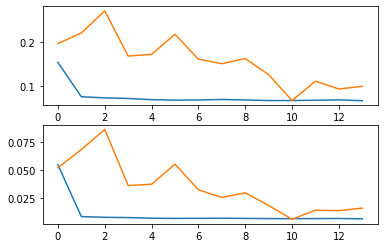

In [10]:
# see results
fig, axs = plt.subplots(2, 1)

#print(model.get_config())

mse = np.max(hist.history['mae'])
val_mse = np.max(hist.history['val_mae'])
print('mae: ', mse, 'val_mae: ', val_mse)

axs[0].plot(hist.history['mae'])
axs[0].plot(hist.history['val_mae'])


axs[1].plot(hist.history['loss'])
axs[1].plot(hist.history['val_loss'])

In [11]:
# Testing the model

from sklearn.metrics import classification_report

#print(test_loader.__getitem__(0)[0].shape, test_loader.__getitem__(0)[1].shape, len(test_loader)) 

# yt = []
# yp = []
for i in range (len(test_loader)):
    sample = test_loader.__getitem__(i)
    print(type(sample[0]))
    ret = model.predict(sample[0], batch_size=batch_size)
    print('predict')
    print(ret)
    print(sample[1])
    print('volume in decibels predicted:')
    print([volume_denormalization(x) for x in ret])

<class 'numpy.ndarray'>
predict
[[0.49997616]
 [0.500023  ]
 [0.74635863]
 [0.7592771 ]
 [0.7572553 ]
 [0.78770053]
 [0.49997616]
 [0.500023  ]
 [0.42914775]
 [0.41612712]
 [0.41582045]
 [0.4498113 ]
 [0.49997616]
 [0.500023  ]
 [0.44901642]
 [0.41676432]
 [0.4165072 ]
 [0.4751332 ]
 [0.49997616]
 [0.500023  ]
 [0.74635863]
 [0.7592771 ]
 [0.7572553 ]
 [0.78770053]]
[0.7797346  0.7797346  0.7797346  0.7797346  0.7797346  0.7797346
 0.52832675 0.52832675 0.52832675 0.52832675 0.52832675 0.52832675
 0.5892351  0.5892351  0.5892351  0.5892351  0.5892351  0.5892351
 0.7797346  0.7797346  0.7797346  0.7797346  0.7797346  0.7797346 ]
volume in decibels predicted:
[array([87.498116], dtype=float32), array([87.501816], dtype=float32), array([106.96233], dtype=float32), array([107.982895], dtype=float32), array([107.823166], dtype=float32), array([110.22835], dtype=float32), array([87.498116], dtype=float32), array([87.501816], dtype=float32), array([81.90267], dtype=float32), array([80.87404],

In [12]:
# loading the model
model_loaded = keras.models.load_model("model.h5")


for i in range (len(test_loader)):
    sample = test_loader.__getitem__(i)
    print(sample[0])
    ret = model_loaded.predict(sample[0], batch_size=batch_size)
    print('predict')
    print('volume in decibels predicted:')
    print([volume_denormalization(x) for x in ret])
    print([volume_denormalization(x) for x in sample[1]])


[[[ 0.0000000e+00]
  [ 0.0000000e+00]
  [-3.0517578e-05]
  ...
  [ 0.0000000e+00]
  [ 3.0517578e-05]
  [ 3.0517578e-05]]

 [[ 0.0000000e+00]
  [ 0.0000000e+00]
  [ 0.0000000e+00]
  ...
  [ 0.0000000e+00]
  [ 0.0000000e+00]
  [ 0.0000000e+00]]

 [[ 0.0000000e+00]
  [-3.0517578e-05]
  [ 0.0000000e+00]
  ...
  [ 1.4343262e-03]
  [ 9.3383789e-03]
  [ 5.5847168e-03]]

 ...

 [[ 3.9672852e-04]
  [ 3.9978027e-03]
  [-2.1606445e-02]
  ...
  [ 7.6293945e-04]
  [ 4.5166016e-03]
  [ 2.0690918e-02]]

 [[ 9.1552734e-03]
  [ 1.8188477e-02]
  [ 3.8757324e-03]
  ...
  [ 9.2468262e-03]
  [ 7.5988770e-03]
  [ 5.7067871e-03]]

 [[ 1.2359619e-02]
  [ 9.1247559e-03]
  [ 5.8898926e-03]
  ...
  [-8.5144043e-03]
  [-1.2847900e-02]
  [-8.9416504e-03]]]
predict
volume in decibels predicted:
[array([87.498116], dtype=float32), array([87.501816], dtype=float32), array([106.96233], dtype=float32), array([107.982895], dtype=float32), array([107.823166], dtype=float32), array([110.22835], dtype=float32), array([87.4